# Writing a PhD Thesis

Before starting to work on my PhD Thesis, my office mate Mehdi gave me the idea of keeping track of my activity by writing down the number of words written per day (much credit goes to him!). Luckily for me, TeXShop features an extremely basic word-counting widget. This likely does not count equations and figures properly, but it should still give a sense of my work pace.  
Each day in which I actually wrote something, I noted down (on a .csv file) the total number of words in the thesis. Let us import this file as a time series with pandas.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# IMPORT THE CSV FILE
df=pd.read_csv('/Users/giulio/Documents/Physics/PhD_Thesis/word_count_phd_thesis.csv',parse_dates=True, index_col="Date",dayfirst=True)


Let's have a look.

            Word Count
Date                  
2018-08-24         532
2018-08-25         684
2018-09-04         927
2018-09-13        1506
2018-09-17        5304
            Word Count
Date                  
2019-01-01       28891
2019-01-02       28838
2019-01-04       29055
2019-01-05       29288
2019-01-06       30937


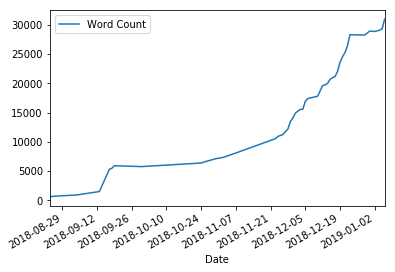

In [9]:
print(df.head())
print(df.tail())
df.plot()

I started writing at the end of august, on the 24th, and wrote the last words on the 6th of January. An immediate feature to notice in the plot is the "jump" on the 17th of September. What happened there? A writing frenzy? Nope, that is just the copy-paste of the article I had published in July '18. Let's keep this "outlier" for now, with the intention of later removing it.
What's also clear is that the graph linearly interpolates between values. This is kind of misleading, as I only noted down the days in which I actually wrote something. So let us fill the gaps with a forward fill and see what that looks like.

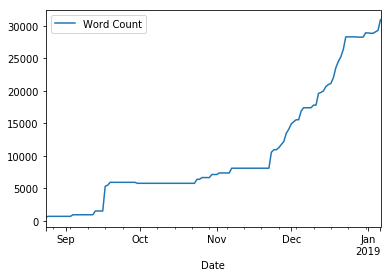

In [10]:
s=pd.Series(df["Word Count"], df.index)
dates_fill=s.asfreq('D',method="ffill")
df_fill = pd.DataFrame(dates_fill)
df_fill.plot()

Now you can see also the periods during which I didn't write anything (the plateaus). In fact, a more meaningful dataset could be the number of words written per day, instead of the total (cumulative) number of words. Let's construct this with a simple loop.

In [11]:
number_words=[532]
for i in range(len(dates_fill.values)-1):
       number_words.append(dates_fill.values[i+1]-dates_fill.values[i])

words_per_day=pd.DataFrame(pd.Series(number_words,name="Word Count", index=dates_fill.index))

Let us look at the stats and visualize it as a stem plot.

        Word Count
count   136.000000
mean    227.477941
std     531.941127
min    -149.000000
25%       0.000000
50%       0.000000
75%     239.250000
max    3798.000000


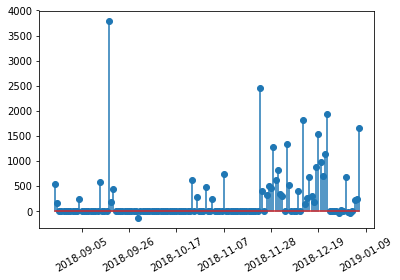

In [12]:
print(words_per_day.describe())

plt.stem(words_per_day.index.values,words_per_day)
plt.xticks(rotation=30)
plt.show()

The copy-paste of the article is clearly visible now. It also looks such that I mostly worked in the end, with the deadline approaching. The deadline to hand in the Thesis was the 7th of january, and this is the last two weeks:

In [13]:
print(words_per_day.tail(15))

            Word Count
Date                  
2018-12-23        1938
2018-12-24           0
2018-12-25           0
2018-12-26           0
2018-12-27           0
2018-12-28         -54
2018-12-29          10
2018-12-30           0
2018-12-31         666
2019-01-01         -22
2019-01-02         -53
2019-01-03           0
2019-01-04         217
2019-01-05         233
2019-01-06        1649


Negative numbers correspond to days in which I made more corrections and remove more stuff than I wrote, obviously. It's nice to see how much I have worked right before Christmas, and that I took a 4-day break to be with the family. The day before the deadline I ran the final sprint, although on that day I wrote only the french summary which involved a lot of copy-paste and translate from the english introduction and conclusion (the actual thesis was already completed on the 5th). 

Let's now remove the outlier from both the cumulative and the per-day dataframes. 

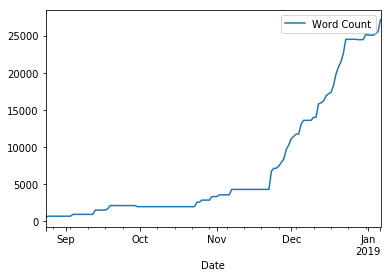

In [14]:
df_fill_no_article=df_fill.copy()
df_fill_no_article.loc["2018-09-17":]=df_fill_no_article.loc["2018-09-17":]-max(words_per_day['Word Count'])
df_fill_no_article.plot()

Now we can clearly distinguish two regimes, where another (smaller) jump appears at the end of november. However, this can sort-of look like an exponential increase. Let's look therefore at a semi-log plot.

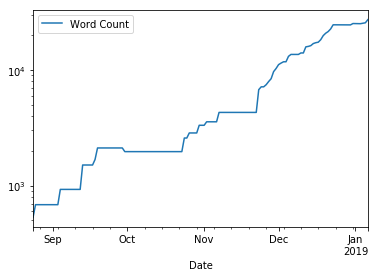

In [15]:
df_fill_no_article.plot(logy=True)

Does that look like a straight line? Not sure. However, if we interpolate the days in which I wrote, as in the original dataframe, we find:

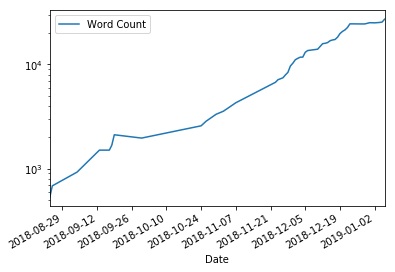

In [16]:
df_no_article=df.copy()
df_no_article.loc["2018-09-17":]=df_no_article.loc["2018-09-17":]-max(words_per_day['Word Count'])
df_no_article.plot(logy=True)

This looks much more like an exponential behavior. Let's find a fit using lmfit (https://lmfit.github.io/lmfit-py). Let us construct three models: an exponential, an exponential with offset, and a sum of two exponentials.

['A', 'alpha', 'B']
['x']
[[Model]]
    Model(exp_offset)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 105
    # data points      = 136
    # variables        = 3
    chi-square         = 2.6792e+08
    reduced chi-square = 2014415.69
    Akaike info crit   = 1977.12062
    Bayesian info crit = 1985.85859
[[Variables]]
    A:      494.928856 +/- 79.3399013 (16.03%) (init = 1)
    alpha:  0.03039103 +/- 0.00120216 (3.96%) (init = 0.1)
    B:     -181.097924 +/- 293.152206 (161.87%) (init = 532)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, alpha) = -0.995
    C(A, B)     = -0.855
    C(alpha, B) =  0.822

['A', 'alpha']
['x']
[[Model]]
    Model(exp_no_off)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 136
    # variables        = 2
    chi-square         = 2.6880e+08
    reduced chi-square = 2005979.12
    Akaike info crit   = 1975.56857
    Bayesian info crit = 1981.39388
[[Var

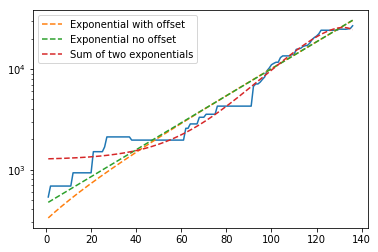

In [17]:
from lmfit import Model

def exp_offset(x, A, alpha, B):
    return A * np.exp(alpha * x) + B

# turn the function into a Model, see lmfit docs
exp_offset_model = Model(exp_offset)

print(exp_offset_model.param_names)
print(exp_offset_model.independent_vars)

# create parameters with initial values
params_exp_offset = exp_offset_model.make_params(A=1,alpha=0.1,B=532)

# fit the data to the model with the parameters
result_exp_offset = exp_offset_model.fit(df_fill_no_article.values.transpose().flatten(), params_exp_offset, x=np.array(range(1,137)))

# print the fit statistics and resulting parameters
print(result_exp_offset.fit_report())

def exp_no_off(x, A, alpha):
    return A * np.exp(alpha * x)

# turn the function into a Model, see lmfit docs
exp_no_offset_model = Model(exp_no_off)

print(exp_no_offset_model.param_names)
print(exp_no_offset_model.independent_vars)

# create parameters with initial values
params_exp_no_offset = exp_no_offset_model.make_params(A=1,alpha=0.1)

# fit the data to the model with the parameters
result_exp_no_offset = exp_no_offset_model.fit(df_fill_no_article.values.transpose().flatten(), params_exp_no_offset, x=np.array(range(1,137)))

# print the fit statistics and resulting parameters
print(result_exp_no_offset.fit_report())

def two_exp(x, A, alpha, B , beta,C):
    return A * np.exp(alpha * x) - B * np.exp(beta * x)+C

# turn the function into a Model, see lmfit docs
two_exp_model = Model(two_exp)

print(two_exp_model.param_names)
print(two_exp_model.independent_vars)

# create parameters with initial values
params_two_exp = two_exp_model.make_params(A=1,alpha=0.01,B=0,beta=0.05,C=1)

# fit the data to the model with the parameters
result_two_exp = two_exp_model.fit(df_fill_no_article.values.transpose().flatten(), params_two_exp, x=np.array(range(1,137)))

# print the fit statistics and resulting parameters
print(result_two_exp.fit_report())

plt.semilogy(range(1,137), df_fill_no_article.values)
#plt.semilogy(range(1,137), result.init_fit, 'b--')
plt.semilogy(range(1,137), result_exp_offset.best_fit, '--', label="Exponential with offset")
plt.semilogy(range(1,137), result_exp_no_offset.best_fit, '--', label="Exponential no offset")
plt.semilogy(range(1,137), result_two_exp.best_fit, '--', label="Sum of two exponentials")
plt.legend()
plt.show()

Let us also see what curve_fit finds, just for fun.

/Users/giulio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


[ 4.94984570e+02  3.03901839e-02 -1.81267751e+02]


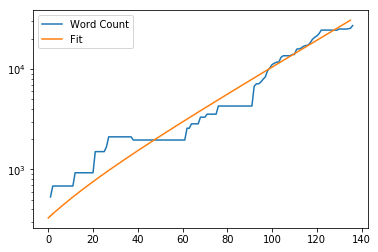

In [67]:
from scipy.optimize import curve_fit

def func(t, a, b,c):
    return a*np.exp(b * t)+c

# initial guess for curve fit coefficients
guess = [1,0.01,532]

# coefficients and curve fit for curve
popt, pcov = curve_fit(func, np.array(range(1,137)), df_fill_no_article.values.transpose().flatten(), p0=guess)

df_fill_fit = func(np.array(range(1,137)), *popt)

print(popt)
#print(pcov)

plt.semilogy(range(1,137), df_fill_no_article.values,  label='Word Count')
plt.semilogy(df_fill_fit, '-', label='Fit')
plt.legend()
plt.show()

Now it might be interesting to resample the interpolated data, in order to get the right interval in the index.

In [20]:
df_no_article_int=df_no_article.copy()
df_no_article_int=df_no_article_int.resample("D").mean().reset_index(drop=True).dropna()
df_no_article_int.index=df_no_article_int.index+1
print(df_no_article_int.head(6))

    Word Count
1        532.0
2        684.0
12       927.0
21      1506.0
25      1506.0
26      1680.0


We should however remove the double entry 1506, coming from removing the outlier.

In [24]:
df_no_article_int=df_no_article_int.drop_duplicates(subset="Word Count")

Let's check whether we find a better fit.

[[Model]]
    Model(exp_no_off)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 70
    # data points      = 46
    # variables        = 2
    chi-square         = 1.0396e+08
    reduced chi-square = 2362804.58
    Akaike info crit   = 677.021772
    Bayesian info crit = 680.679055
[[Variables]]
    A:      720.300264 +/- 96.3642856 (13.38%) (init = 1)
    alpha:  0.02727161 +/- 0.00109403 (4.01%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, alpha) = -0.994

[[Model]]
    Model(two_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7351
    # data points      = 46
    # variables        = 5
    chi-square         = 25824733.0
    reduced chi-square = 629871.536
    Akaike info crit   = 618.957284
    Bayesian info crit = 628.100491
[[Variables]]
    A:      169.253267 +/- 53095.8590 (31370.66%) (init = 1)
    alpha:  0.06335986 +/- 0.37393968 (590.18%) (init = 0.01)
    B:      124.196546 +/- 531

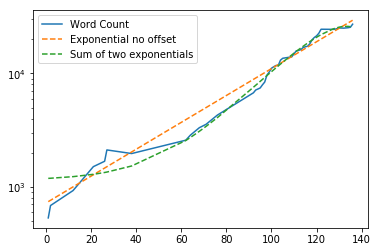

In [25]:
# single exponential "exp_no_offset_model" and parameters were defined above
result_exp_no_offset_no_fill = exp_no_offset_model.fit(df_no_article_int.values.transpose().flatten(), params_exp_no_offset, x=df_no_article_int.index.values)

# print the fit statistics and resulting parameters
print(result_exp_no_offset_no_fill.fit_report())

# fit the data to the model with the parameters
result_two_exp_no_fill = two_exp_model.fit(df_no_article_int.values.transpose().flatten(), params_two_exp, x=df_no_article_int.index.values)

# print the fit statistics and resulting parameters
print(result_two_exp_no_fill.fit_report())


plt.semilogy(df_no_article_int.index.values, df_no_article_int.values, label="Word Count")
plt.semilogy(df_no_article_int.index.values, result_exp_no_offset_no_fill.best_fit, '--', label="Exponential no offset")
plt.semilogy(df_no_article_int.index.values, result_two_exp_no_fill.best_fit, '--', label="Sum of two exponentials")
plt.legend()
plt.show()

In general, it looks such that I work with an exponential flow, with a generic exponent $0.02\lesssim\alpha\lesssim 0.07$, but it seems that there are two (maybe three) regimes. It is therefore useful to look again at the stem plot, this time without the outlier.

        Word Count
count   136.000000
mean    199.551471
std     433.733470
min    -149.000000
25%       0.000000
50%       0.000000
75%     234.250000
max    2453.000000


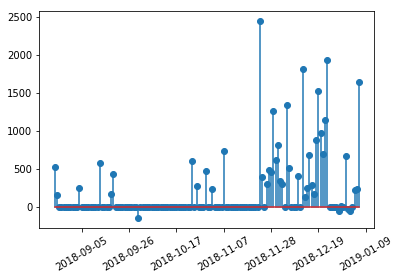

In [26]:
words_per_day_no_article=words_per_day.copy()
words_per_day_no_article.loc["2018-09-17","Word Count"]=0

print(words_per_day_no_article.describe())

plt.stem(words_per_day_no_article.index.values,words_per_day_no_article)
plt.xticks(rotation=30)
plt.show()

Four periods of activity may be noticed.
 - From the end of august to mid-septmeber. That's when I said "I'm gonna be diligent and start early". This period ends in the days after I copy-paste the article (Sept. 17th), which apparently made me feel OK about how things were going.  
 - After approximatively a month of inactivity (with a small negative fluctation!), in mid-october I went back to work for a short time. I recall expanding the arguments of the article, written in PRL-style, and massaging here and there to get a more thesis-style text. 
 - Another (shorter) period of inactivity followed, after which I evidently panicked and wrote 2453 words in a day. In some sense, this "unlocked" my writing and I wrote for a good month until the thesis was done. 
 - Then Christmas came, after that I made corrections (many negative values!) and wrote the French summary.
 
Let's look now at a rather interesting property of my writing. This concentration in clusters seems to point to the fact that the more I did in a given time interval, the more it was likely that I wrote on the following day. Let's look therefore at the conditional probability that I was writing something if I wrote something on the day before.

In [27]:
cond_prob=0
for i in range(1,len(words_per_day_no_article)):
    if words_per_day_no_article["Word Count"].iloc[i-1]!=0 and words_per_day_no_article["Word Count"].iloc[i]!=0 :
        cond_prob = cond_prob+1
cond_prob=cond_prob/len(df_no_article_int)
  
print(cond_prob)

0.6304347826086957


Note that I'm dividing by the number of days in which I did write, not the total numebr of days. 

In [35]:
cond_prob2=0
for i in range(1,len(words_per_day_no_article)):
    if (words_per_day_no_article["Word Count"].iloc[i-2]!=0 or words_per_day_no_article["Word Count"].iloc[i-1]!=0)  and words_per_day_no_article["Word Count"].iloc[i]!=0 :
        cond_prob2 = cond_prob2+1
cond_prob2=cond_prob2/len(df_no_article_int)
  
print(cond_prob2)

cond_prob3=0
for i in range(1,len(words_per_day_no_article)):
    if (words_per_day_no_article["Word Count"].iloc[i-3]!=0  or words_per_day_no_article["Word Count"].iloc[i-2]!=0 or words_per_day_no_article["Word Count"].iloc[i-1]!=0)  and words_per_day_no_article["Word Count"].iloc[i]!=0 :
        cond_prob3 = cond_prob3+1
cond_prob3=cond_prob3/len(df_no_article_int)
  
print(cond_prob3)

cond_prob4=0
for i in range(1,len(words_per_day_no_article)):
    if (words_per_day_no_article["Word Count"].iloc[i-4]!=0 or words_per_day_no_article["Word Count"].iloc[i-3]!=0  or words_per_day_no_article["Word Count"].iloc[i-2]!=0 or words_per_day_no_article["Word Count"].iloc[i-1]!=0)  and words_per_day_no_article["Word Count"].iloc[i]!=0 :
        cond_prob4 = cond_prob4+1
cond_prob4=cond_prob4/len(df_no_article_int)
  
print(cond_prob4)

cond_prob5=0
for i in range(1,len(words_per_day_no_article)):
    if (words_per_day_no_article["Word Count"].iloc[i-5]!=0 or words_per_day_no_article["Word Count"].iloc[i-4]!=0 or words_per_day_no_article["Word Count"].iloc[i-3]!=0  or words_per_day_no_article["Word Count"].iloc[i-2]!=0 or words_per_day_no_article["Word Count"].iloc[i-1]!=0)  and words_per_day_no_article["Word Count"].iloc[i]!=0 :
        cond_prob5 = cond_prob5+1
cond_prob5=cond_prob5/len(df_no_article_int)
  
print(cond_prob5)

0.7391304347826086
0.7608695652173914
0.8043478260869565
0.8695652173913043


The richest part is the third period, lasting for one month, in which I wrote most of the Thesis. 

        Word Count
count    31.000000
mean    651.806452
std     636.973962
min       0.000000
25%     208.000000
50%     457.000000
75%     926.500000
max    2453.000000
Percentage of Thesis written in this month: 74.45373816279155% .


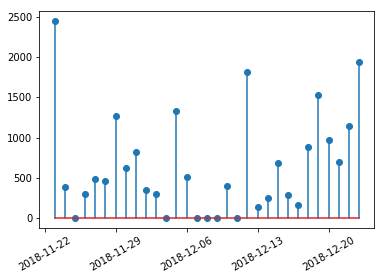

In [66]:
third_period = words_per_day_no_article.loc["2018/11/23":"2018/12/23"]
print(third_period.describe())

#Percentage of Thesis written in this month:
percentage= (third_period.sum()*100/words_per_day_no_article.sum()).values[0]
print(f'Percentage of Thesis written in this month: {percentage}% .') 

plt.stem(third_period.index.values,third_period)
plt.xticks(rotation=30)
plt.show()


Here the conditional probaility is rather different!

In [47]:
cond_prob_third=0
for i in range(1,len(third_period)):
    if third_period["Word Count"].iloc[i-1]!=0 and third_period["Word Count"].iloc[i]!=0 :
        cond_prob_third = cond_prob_third+1
cond_prob_third=cond_prob_third/(third_period != 0).values.sum()
  
print(cond_prob_third)

0.8461538461538461


The quantity of writing seems not to matter much, in the sense that there are as many days in which I wrote less  as the ones in which I wrote more (w.r.t. the day before).

I think it is nice to see that I definitely work at an exponential pace, whatever that may be, instead of for example linearly. I can think of a couple of people in my lab that will definitely work at a linear pace, withouth having later to pull all-nighters or extra work hours in the weekend, as Yours Truly did.